# Replication for results in Davidson et al. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language"

In [2]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

## Loading the data

In [22]:
df = pd.read_csv("data/train/training_data.csv")

In [86]:
df.size

157968

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


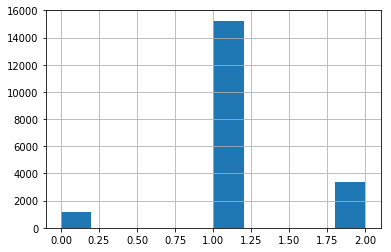

In [6]:
df['class'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [104]:
tweets=df.tweet

## Feature generation

In [28]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [29]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [111]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

In [106]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [107]:
len(tweet_tags)

19746

In [108]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [110]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [71]:
#Now get other features
#sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    #sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms,
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweet):
    feats=[]
    for t in tweet:
        feats.append(other_features(t))
    return np.array(feats)

In [72]:
#other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                       # "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        #"vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]
        
other_features_names = ["num_chars", "num_chars_total", "num_terms", "num_words", "num_unique_words", "num_hashtags", \
                    "num_mentions", "num_urls", "is_retweet"]

In [73]:
feats = get_feature_array(tweets)

In [112]:
#Now join them all up
print(tfidf.shape, pos.shape, feats.shape)
M = np.concatenate([tfidf,pos,feats],axis=1)

(19746, 3269) (19746, 548) (19746, 9)


In [113]:
M.shape

(19746, 3826)

In [ ]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [48]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [136]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [137]:
def train_model(X, y):
    X = pd.DataFrame(M)
    y = df['class'].astype(int)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
    pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l1", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])
    param_grid = [{}] # Optionally add parameters here
    grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X, y), 
                           verbose=2)
    model = grid_search.fit(X, y)
    return model

In [138]:
LR = train_model(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  47.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.0s remaining:    0.0s


[CV] ................................................. , total=  20.3s
[CV]  ................................................................
[CV] ................................................. , total=  20.3s
[CV]  ................................................................
[CV] ................................................. , total=  14.7s
[CV]  ................................................................
[CV] ................................................. , total=  13.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished


## Test Data

In [76]:
testing = pd.read_csv("data/test/testing_data.csv")
dev = pd.read_csv("data/dev/development_data.csv")
test = pd.concat([testing, dev], sort=False)

In [142]:
test.shape

(4937, 8)

In [114]:
test_tweets = test.tweet
test_feats = get_feature_array(test_tweets)

In [115]:
test_tfidf = vectorizer.transform(test_tweets).toarray()

In [116]:
test_tweet_tags = []
for t in test_tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    test_tweet_tags.append(tag_str)

In [117]:
test_pos = pos_vectorizer.transform(pd.Series(test_tweet_tags)).toarray()

In [135]:
test_tfidf.shape, tfidf.shape, test_pos.shape, pos.shape, test_feats.shape, feats.shape

((4937, 3269), (19746, 3269), (4937, 548), (19746, 548), (4937, 9), (19746, 9))

In [119]:
M_test = np.concatenate([test_tfidf,test_pos,test_feats],axis=1)

In [129]:
X_test =  pd.DataFrame(M_test)
y_test = test['class'].astype(int)

In [130]:
y_test.shape

(4937,)

In [139]:
y_preds = LR.predict(X_test)

In [132]:
y_preds.shape

(4937,)

In [162]:
tweets = test[['tweet','class']]

In [163]:
misses = np.where(np.asarray(y_test) != y_preds)
missed_preds = []
for i in range(len(y_test)):
    if np.asarray(y_test)[i] != y_preds[i]:
        missed_preds.append(y_preds[i])


missed = [list(y_test.index)[i] for i in misses[0]]
missed_tweets = tweets.iloc[missed]
missed_tweets.loc[:,'prediction'] = missed_preds

In [161]:
corrects = np.where(np.asarray(y_test) == y_preds)
correct_preds = []
for i in range(len(y_test)):
    if np.asarray(y_test)[i] == y_preds[i]:
        correct_preds.append(y_preds[i])


correct = [list(y_test.index)[i] for i in corrects[0]]
correct_tweets = tweets .iloc[correct]
correct_tweets.loc[:,'prediction'] = correct_preds

In [166]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 700)

In [167]:
correct_tweets.loc[correct_tweets['class']==2][['tweet']]

,tweet
18,RT @DamnFoodPorn: Oreo Cookie Pancakes #FoodPorn http://t.co/q6EvCvM3sO
35,Fairy Tale Hat - free crochet pattern for child and adult at http://t.co/0lRaBLMHB2 http://t.co/99zVbmYVe9
58,"RT @daraobriain: Tommy Voeckler keeps the yellow, Andy Schleck does the break of the tour, and Contador is broken. Incredible day for #tdf"
63,Watching #Steelers colts getting blinded by the Steelers uniys look like bunch of bumblebees
65,RT @netflix: Here's your first look at Charlie Cox as Matt Murdock in #Marvel's @Daredevil on #Netflix #NYCC http://t.co/SIYuCgok8J
78,Ravioli stuffed wit lobster nd a nice stuffed clam #eating betterthanamobster http://t.co/PzdoESaR
84,I want a four loco right now so I can chug it and go straight to sleep.
100,#Yankees Damn. Well Joe that move to the bullpen really helped.
103,Next time you leave magic trash in my jacket try not to have your initials written on them. @whatupag http://t.co/tFV1cZtr
122,Yankees getting killed


In [149]:
missed_tweets.to_csv("test_baseline_missed.csv", sep='\t')

## Evaluating the results

In [140]:
report = classification_report( y_test, y_preds )

***Note: Results in paper are from best model retrained on the entire dataset (see the other notebook). Here the results are reported after using cross-validation and only for the held-out set.***

In [141]:
print(report)

              precision    recall  f1-score   support

           0       0.30      0.45      0.36       265
           1       0.94      0.86      0.90      3875
           2       0.66      0.81      0.73       797

   micro avg       0.83      0.83      0.83      4937
   macro avg       0.64      0.71      0.66      4937
weighted avg       0.86      0.83      0.84      4937



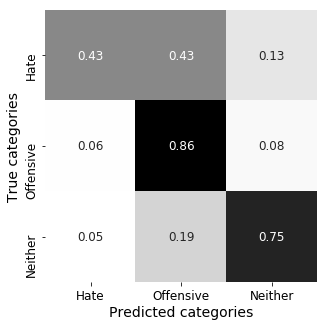

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

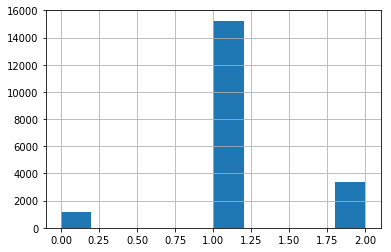

In [29]:
#True distribution
y.hist()

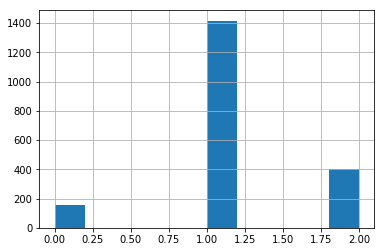

In [30]:
pd.Series(y_preds).hist()

In [31]:
len(y_preds)

1975

In [32]:
tweets = df[['tweet', 'class']]
misses = np.where(np.asarray(y_test) != y_preds)
missed_preds = []
for i in range(len(y_test)):
    if np.asarray(y_test)[i] != y_preds[i]:
        missed_preds.append(y_preds[i])
    

missed = [list(y_test.index)[i] for i in misses[0]]

In [33]:
missed_tweets = tweets.iloc[missed]

In [34]:
missed_tweets.loc[:,'prediction'] = missed_preds
missed_tweets

/anaconda2/envs/nlu/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda2/envs/nlu/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,tweet,class,prediction
8500,@TonyO97 fuck i look like shopping at that tra...,1,0
2626,RT @DessantiGina: @TonyJRodriguez @WolfVanHale...,0,2
1739,Dis nicca lame,2,1
6956,"@DivaMonRoe2uHoE @CheefPolo hoe hoe hoe, merry...",2,1
7172,Gonna straight hip check the next hillbilly wh...,1,2
5000,RT @_LexC__: I'm convinced that some of y'all ...,1,2
19415,They're calling it #Sandy because the wind is ...,1,2
5116,I really just want to kill some towel head ter...,0,2
10399,@operationSAFE @GaltsGirl lived there and can ...,2,0
7983,do they even make dresses any more that have s...,1,2


In [37]:
len(missed_tweets[(missed_tweets['class'] == 2)]), len(missed_tweets[(missed_tweets['class'] == 1)])

(90, 206)

In [130]:
missed_tweets.to_csv(r'/Users/srizkall/Desktop/NLU/CS224U_Final_Project_Hate_Speech_Detection_Explainability/baseline_missed.csv')